# Time Series Analysis

Sources:
- https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html
- https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
- https://www.curiousily.com/posts/time-series-forecasting-with-lstm-for-daily-coronavirus-cases/

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import torch
from sklearn.preprocessing import MinMaxScaler
from torch import nn, optim

In [11]:
def summary_view(data_list):
    fig = make_subplots(rows=1, cols=3,
                        specs=[[{"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}]])

    fig.add_trace(
        go.Indicator(
            mode="number",
            value=sum(data_list[0].iloc[:, -2]),
            title="Cases",
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Indicator(
            mode="number",
            value=sum(data_list[1].iloc[:, -2]),
            title="Recovered",
        ),
        row=1, col=2
    )

    fig.add_trace(
        go.Indicator(
            mode="number",
            value=sum(data_list[2].iloc[:, -2]),
            title="Deaths",
        ),
        row=1, col=3
    )

    fig.update_layout(height=200, width=600, title_text="Today Summary")
    # st.plotly_chart(fig)
    return fig

In [6]:
def header_view(data_list):
    message = data_list[0]["Country/Region"] + "<br>"
    message += "Confirmed: " + data_list[0].iloc[:, -2].astype(str)

    fig2 = go.Figure(data=go.Scattergeo(
        locationmode="country names",
        lon=data_list[0]["Long"],
        lat=data_list[0]["Lat"],
        hovertext=message,
        showlegend=False,
        marker=dict(
            size=7,
            opacity=0.9,
            reversescale=True,
            autocolorscale=True,
            line=dict(
                width=1,
            ),
            cmin=0,
            color=data_list[0].iloc[:, -3],
            cmax=max(data_list[0].iloc[:, -3]),
            colorbar_title="Live Confirmed Cases",
        )),
    )

    fig2.update_layout(
        title="COVID-19 Worldwide Cases",
        showlegend=True,
        legend=dict(x=0.65, y=0.8),
        geo=dict(
            projection_type="orthographic",
            showcoastlines=True,
            showland=True,
            showocean=True,
            lakecolor="LightBlue"
        ),
    )

    # st.plotly_chart(fig)
    return fig2

In [7]:
def world_map(resources, df2):
    datasets = []
    for link in resources:
        df = pd.read_csv(link)
        df = df[df['Country/Region'] != 'Diamond Princess']
        df = df[df['Country/Region'] != 'MS Zaandam']
        if len(datasets) == 0:
            fig2 = header_view([df])
        df = df.drop(['Province/State'], axis=1)
        df = df.reset_index(drop=True)
        df = df.groupby('Country/Region').sum()
        df = df.reset_index()
        df.loc[df.loc[df['Country/Region'] == 'US'].index,
               'Country/Region'] = 'United States of America'
        df.loc[df.loc[df['Country/Region'] == 'United Kingdom'].index,
               'Country/Region'] = 'United Kingdom of Great Britain and Northern Ireland'
        df.loc[df.loc[df['Country/Region'] == 'Russia'].index,
               'Country/Region'] = 'Russian Federation'
        df.loc[df.loc[df['Country/Region'] == 'Venezuela'].index,
               'Country/Region'] = 'Venezuela (Bolivarian Republic of)'
        df.loc[df.loc[df['Country/Region'] == 'Bolivia'].index,
               'Country/Region'] = 'Bolivia (Plurinational State of)'
        df.loc[df.loc[df['Country/Region'] == 'Taiwan*'].index,
               'Country/Region'] = 'Taiwan, Province of China'
        df.loc[df.loc[df['Country/Region'] == 'Syria'].index,
               'Country/Region'] = 'Syrian Arab Republic'
        df.loc[df.loc[df['Country/Region'] == 'Korea, South'].index,
               'Country/Region'] = 'Korea, Republic of'
        df.loc[df.loc[df['Country/Region'] == 'Iran'].index,
               'Country/Region'] = 'Iran (Islamic Republic of)'
        df.loc[df.loc[df['Country/Region'] == 'Cote d\'Ivoire'].index,
               'Country/Region'] = 'Côte d\'Ivoire'
        df.loc[df.loc[df['Country/Region'] ==
                      'Congo (Kinshasa)'].index, 'Country/Region'] = 'Congo, Democratic Republic of the'
        df.loc[df.loc[df['Country/Region'] ==
                      'Congo (Brazzaville)'].index, 'Country/Region'] = 'Congo'
        df.loc[df.loc[df['Country/Region'] == 'Moldova'].index,
               'Country/Region'] = 'Moldova, Republic of'
        df.loc[df.loc[df['Country/Region'] == 'Tanzania'].index,
               'Country/Region'] = 'Tanzania, United Republic of'
        df.loc[df.loc[df['Country/Region'] == 'Brunei'].index,
               'Country/Region'] = 'Brunei Darussalam'
        code2 = []
        for i in df['Country/Region']:
            try:
                code2.append(df2[df2['name'] == i]['alpha-3'].values[0])
            except:
                code2.append('NA')

        df['code'] = code2
        df.loc[df.loc[df['Country/Region'] == 'United Kingdom of Great Britain and Northern Ireland'].index,
               'Country/Region'] = 'United Kingdom'
        datasets.append(df)

    fig = summary_view(datasets)

    for i in range(len(datasets)):
        datasets[i] = datasets[i].drop(
            ['Lat', 'Long'], axis=1)
        datasets[i] = datasets[i].melt(
            id_vars=["Country/Region", "code"],
            var_name="Dates",
            value_name="Cases")

    return datasets, fig, fig2

In [57]:
df2 = pd.read_csv('../data/all.csv')
resources = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
             'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv',
             'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
             ]

data_list, fig, fig2 = world_map(resources, df2)

In [58]:
data_list[0].set_index('Dates', inplace=True)
data_list[1].set_index('Dates', inplace=True)
data_list[2].set_index('Dates', inplace=True)
#data_list[0].index = data_list[0].index.map(str)
data_list[0]

,Country/Region,code,Cases
Dates,,,
1/22/20,Afghanistan,AFG,0
1/22/20,Albania,ALB,0
1/22/20,Algeria,DZA,0
1/22/20,Andorra,AND,0
1/22/20,Angola,AGO,0
...,...,...,...
7/7/20,West Bank and Gaza,NA,4647
7/7/20,Western Sahara,ESH,10
7/7/20,Yemen,YEM,1297


In [24]:
data_list[0][data_list[0]['Country/Region']==place]['Cases']

Dates
1/22/20       0
1/23/20       0
1/24/20       0
1/25/20       0
1/26/20       0
           ... 
7/3/20     2752
7/4/20     2819
7/5/20     2893
7/6/20     2964
7/7/20     3038
Name: Cases, Length: 168, dtype: int64

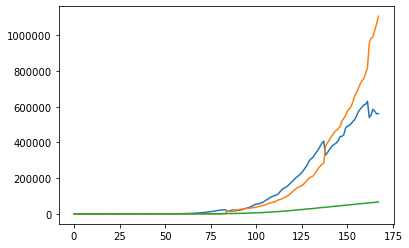

In [92]:
place = 'Brazil'
plt.plot(data_list[0][data_list[0]['Country/Region']==place]['Cases'].values - data_list[1][data_list[1]['Country/Region']==place]['Cases'].values)
plt.plot(data_list[1][data_list[0]['Country/Region']==place]['Cases'].values)
plt.plot(data_list[2][data_list[0]['Country/Region']==place]['Cases'].values)

# SIR Time Series Prediction

In [80]:
class Learner(object):
    def __init__(self, country, loss, start_date, predict_range,s_0, i_0, r_0):
        self.country = country
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0
    

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data, recovered, death, country, s_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        return new_index, extended_actual, extended_recovered, extended_death, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))


    def train(self):
        recovered = data_list[1][data_list[1]['Country/Region']==self.country]['Cases'] #self.load_recovered(self.country)
        death = data_list[2][data_list[2]['Country/Region']==self.country]['Cases']
        data = data_list[0][data_list[0]['Country/Region']==self.country]['Cases'] - data_list[1][data_list[1]['Country/Region']==self.country]['Cases']
        
        optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, self.s_0, self.i_0, self.r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
        print(optimal)
        beta, gamma = optimal.x
        new_index, extended_actual, extended_recovered, extended_death, prediction = self.predict(beta, gamma, data, recovered, death, self.country, self.s_0, self.i_0, self.r_0)
        df = pd.DataFrame({'Infected data': extended_actual, 'Recovered data': extended_recovered, 'Death data': extended_death, 'Susceptible': prediction.y[0], 'Infected': prediction.y[1], 'Recovered': prediction.y[2]}, index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.country)
        df.plot(ax=ax)
        print(f"country={self.country}, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
        fig.savefig(f"{self.country}.png")


def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

      fun: 5122.105205084214
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.48768867e+10, 1.36091060e+05])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 612
      nit: 29
   status: 2
  success: False
        x: array([6.82782652e-07, 1.84218310e-02])
country=Italy, beta=0.00000068, gamma=0.01842183, r_0:0.00003706


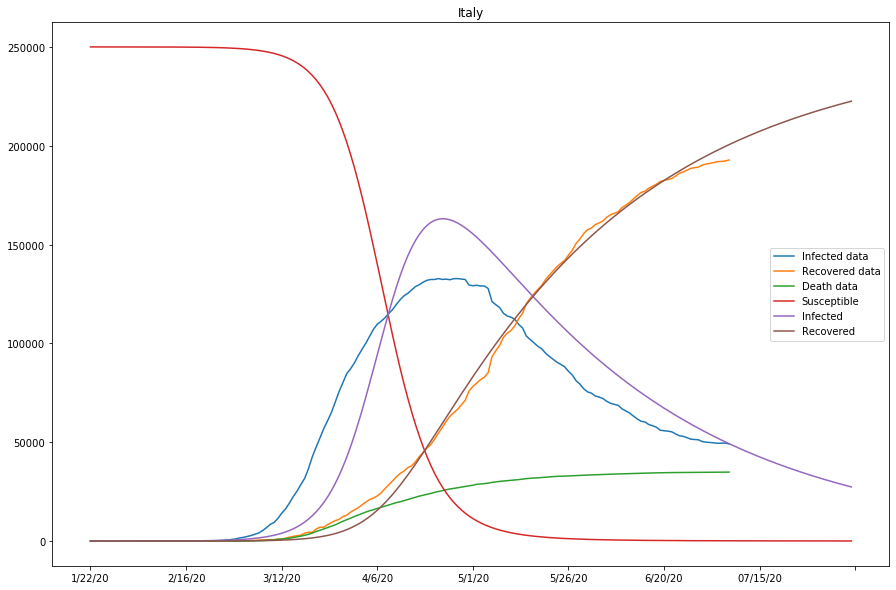

In [84]:
S_0,I_0,R_0 = 250000, 2, 0 

learner = Learner('Italy', loss, '1/22/20', 200, S_0, I_0, R_0)
learner.train()

In [93]:
from sklearn.linear_model import LinearRegression

y = data_list[0][data_list[0]['Country/Region']==place]['Cases'].values - data_list[1][data_list[1]['Country/Region']==place]['Cases'].values
X = np.array([i for i in range(len(y))])
reg = LinearRegression().fit(X.reshape(-1, 1), y)
reg.score(X.reshape(-1, 1), y)

0.72448390813261

In [ ]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X2, Y, test_size = 0.30, random_state = 101, shuffle=False)

## Vector Autoregression and Causality Test

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [110]:
# place = 'Italy'
# it = data_list[0][data_list[0]['Country/Region']==place]['Cases'].values - data_list[1][data_list[1]['Country/Region']==place]['Cases'].values
# plt.plot(it)
# place2 = 'France'
# plt.plot(data_list[0][data_list[0]['Country/Region']==place2]['Cases'].values- data_list[1][data_list[1]['Country/Region']==place2]['Cases'].values)
# place2 = 'Spain'
# plt.plot(data_list[0][data_list[0]['Country/Region']==place2]['Cases'].values- data_list[1][data_list[1]['Country/Region']==place2]['Cases'].values)
# place2 = 'Germany'
# plt.plot(data_list[0][data_list[0]['Country/Region']==place2]['Cases'].values- data_list[1][data_list[1]['Country/Region']==place2]['Cases'].values)
# #plt.plot(data_list[1][data_list[0]['Country/Region']==place2]['Cases'].values)
# #plt.plot(data_list[2][data_list[0]['Country/Region']==place]['Cases'].values)

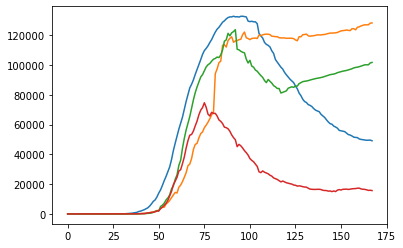

In [115]:
places = ['Italy', 'France', 'Spain', 'Germany']
ex = []
for j, i in enumerate(places):
    ex.append(data_list[0][data_list[0]['Country/Region']==i]['Cases'].values - data_list[1][data_list[1]['Country/Region']==i]['Cases'].values)
    plt.plot(ex[j])
    
plt.show()

In [116]:
d = dict(zip(places, ex))
df = pd.DataFrame(data=d)
df.head()

,Italy,France,Spain,Germany
0,0,0,0,0
1,0,0,0,0
2,0,2,0,0
3,0,3,0,0
4,0,3,0,0


In [117]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,Italy_x,France_x,Spain_x,Germany_x
Italy_y,1.0,0.0,0.0,0.0
France_y,0.0,1.0,0.0,0.0
Spain_y,0.0,0.0,1.0,0.0
Germany_y,0.0,0.0,0.0,1.0


In [118]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Italy  ::  83.19     > 40.1749   =>   True
France ::  36.38     > 24.2761   =>   True
Spain  ::  5.86      > 12.3212   =>   False
Germany ::  1.2       > 4.1296    =>   False


In [119]:
nobs = 7
df_train, df_test = df[0:-nobs], df[-nobs:]

In [120]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [121]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Italy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.4887
 No. Lags Chosen       = 10
 Critical value 1%     = -3.475
 Critical value 5%     = -2.881
 Critical value 10%    = -2.577
 => P-Value = 0.1182. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "France" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.941
 No. Lags Chosen       = 4
 Critical value 1%     = -3.473
 Critical value 5%     = -2.88
 Critical value 10%    = -2.577
 => P-Value = 0.7742. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Spain" 
    -----------------------------------------------
 Null Hypothesis: Data has unit

In [122]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [123]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Italy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8565
 No. Lags Chosen       = 11
 Critical value 1%     = -3.475
 Critical value 5%     = -2.881
 Critical value 10%    = -2.577
 => P-Value = 0.3528. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "France" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0924
 No. Lags Chosen       = 3
 Critical value 1%     = -3.473
 Critical value 5%     = -2.88
 Critical value 10%    = -2.577
 => P-Value = 0.0271. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Spain" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary

In [124]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [125]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Italy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.3361
 No. Lags Chosen       = 8
 Critical value 1%     = -3.475
 Critical value 5%     = -2.881
 Critical value 10%    = -2.577
 => P-Value = 0.0133. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "France" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.9015
 No. Lags Chosen       = 10
 Critical value 1%     = -3.475
 Critical value 5%     = -2.881
 Critical value 10%    = -2.577
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Spain" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level   

In [126]:
# Third Differencing
df_differenced = df_differenced.diff().dropna()
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Italy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.0548
 No. Lags Chosen       = 13
 Critical value 1%     = -3.477
 Critical value 5%     = -2.882
 Critical value 10%    = -2.578
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "France" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.0494
 No. Lags Chosen       = 14
 Critical value 1%     = -3.477
 Critical value 5%     = -2.882
 Critical value 10%    = -2.578
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Spain" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    =

In [127]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  61.1311083971632
BIC :  61.52043907300375
FPE :  3.539488293358994e+26
HQIC:  61.289229230851596 

Lag Order = 2
AIC :  60.291953664097306
BIC :  60.995766588847204
FPE :  1.5299794947663458e+26
HQIC:  60.57781200077338 

Lag Order = 3
AIC :  59.40663904277132
BIC :  60.42765908199584
FPE :  6.319193967218161e+25
HQIC:  59.821354433401964 

Lag Order = 4
AIC :  58.67554616604581
BIC :  60.016538224254425
FPE :  3.048142780660359e+25
HQIC:  59.22025376948461 

Lag Order = 5
AIC :  58.053998625441906
BIC :  59.71776846463775
FPE :  1.6427071652300742e+25
HQIC:  58.72984949534044 

Lag Order = 6
AIC :  57.704445785670956
BIC :  59.69384086517508
FPE :  1.164020046915051e+25
HQIC:  58.51260716357151 

Lag Order = 7
AIC :  57.25583798590972
BIC :  59.57374832412516
FPE :  7.486602857918761e+24
HQIC:  58.197493600653814 

Lag Order = 8
AIC :  56.872010048537724
BIC :  59.52136910734243
FPE :  5.151132991635053e+24
HQIC:  57.948360422126775 

Lag Order = 9
AIC :  56.80831

C:\Users\hp\Anaconda3\envs\pysyft\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



In [128]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,63.60,63.68,4.168e+27,63.63
1,61.44,61.85,4.825e+26,61.61
2,60.59,61.32,2.058e+26,60.89
3,59.69,60.75,8.369e+25,60.12
4,58.94,60.33,3.963e+25,59.50
5,58.29,60.01,2.090e+25,58.99
6,57.92,59.96,1.446e+25,58.75
7,57.44,59.81,9.048e+24,58.41
8,57.03,59.73,6.038e+24,58.12
9,56.93,59.95,5.549e+24,58.16


In [129]:
model_fitted = model.fit(9)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 08, Jul, 2020
Time:                     19:47:02
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    59.7921
Nobs:                     149.000    HQIC:                   58.0206
Log likelihood:          -4929.91    FPE:                4.89730e+24
AIC:                      56.8083    Det(Omega_mle):     2.01674e+24
--------------------------------------------------------------------
Results for equation Italy
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             -0.657867        60.499178           -0.011           0.991
L1.Italy          -1.347365         0.097985          -13.751           0.000
L1.France          0.065661         0.035639            1.842           

In [131]:
from statsmodels.stats.stattools import durbin_watson

def adjust(val, length= 6): return str(val).ljust(length)

out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

Italy  : 1.89
France : 2.02
Spain  : 2.03
Germany : 2.04


In [132]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

9


array([[ -162.,   131.,   -73., -1115.],
       [ -638.,   216.,   118.,   315.],
       [  831.,  -558.,    70.,  -173.],
       [  534.,   384.,   -20.,   600.],
       [ -948.,  1563.,   -47.,  -242.],
       [  158., -2804.,   126.,  -349.],
       [  820.,   570.,  -408.,   270.],
       [ -707.,  3136.,   162.,    97.],
       [ -685., -3846.,   202.,  -330.]])

In [133]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,Italy_2d,France_2d,Spain_2d,Germany_2d
161,1068.425636,2069.388590,-19.256774,-298.444590
162,-484.283353,-726.533255,41.421948,821.071256
163,214.061442,922.598312,-166.374267,-119.552989
164,86.082993,-1752.419218,-616.257293,-318.452261
165,-129.448160,1354.310646,1274.348279,465.836600
166,44.241514,528.812608,-324.378712,-648.145540
167,-233.539525,-1742.056584,-989.531853,71.230828


In [134]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [148]:
def invert_transformation(df_train, df_forecast, second_diff=1):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff==2:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 3rd Diff
        elif second_diff==3:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [155]:
df_results = invert_transformation(df_train, df_forecast, second_diff=3)        
df_results.loc[:, ['Italy', 'France', 'Spain', 'Germany']]

,Italy,France,Spain,Germany
161,50488.425636,127999.388590,99176.743226,17065.555410
162,50162.567919,129608.243924,99499.908401,17634.182075
163,50050.771644,132139.697571,99656.699309,18083.255751
164,50025.058362,132918.732000,99197.232924,18213.877166
165,49869.896920,135052.077075,100012.114818,18810.335181
166,49758.976992,137714.234758,100502.618001,18758.647656
167,49414.517539,138634.335856,100003.589331,18778.190958


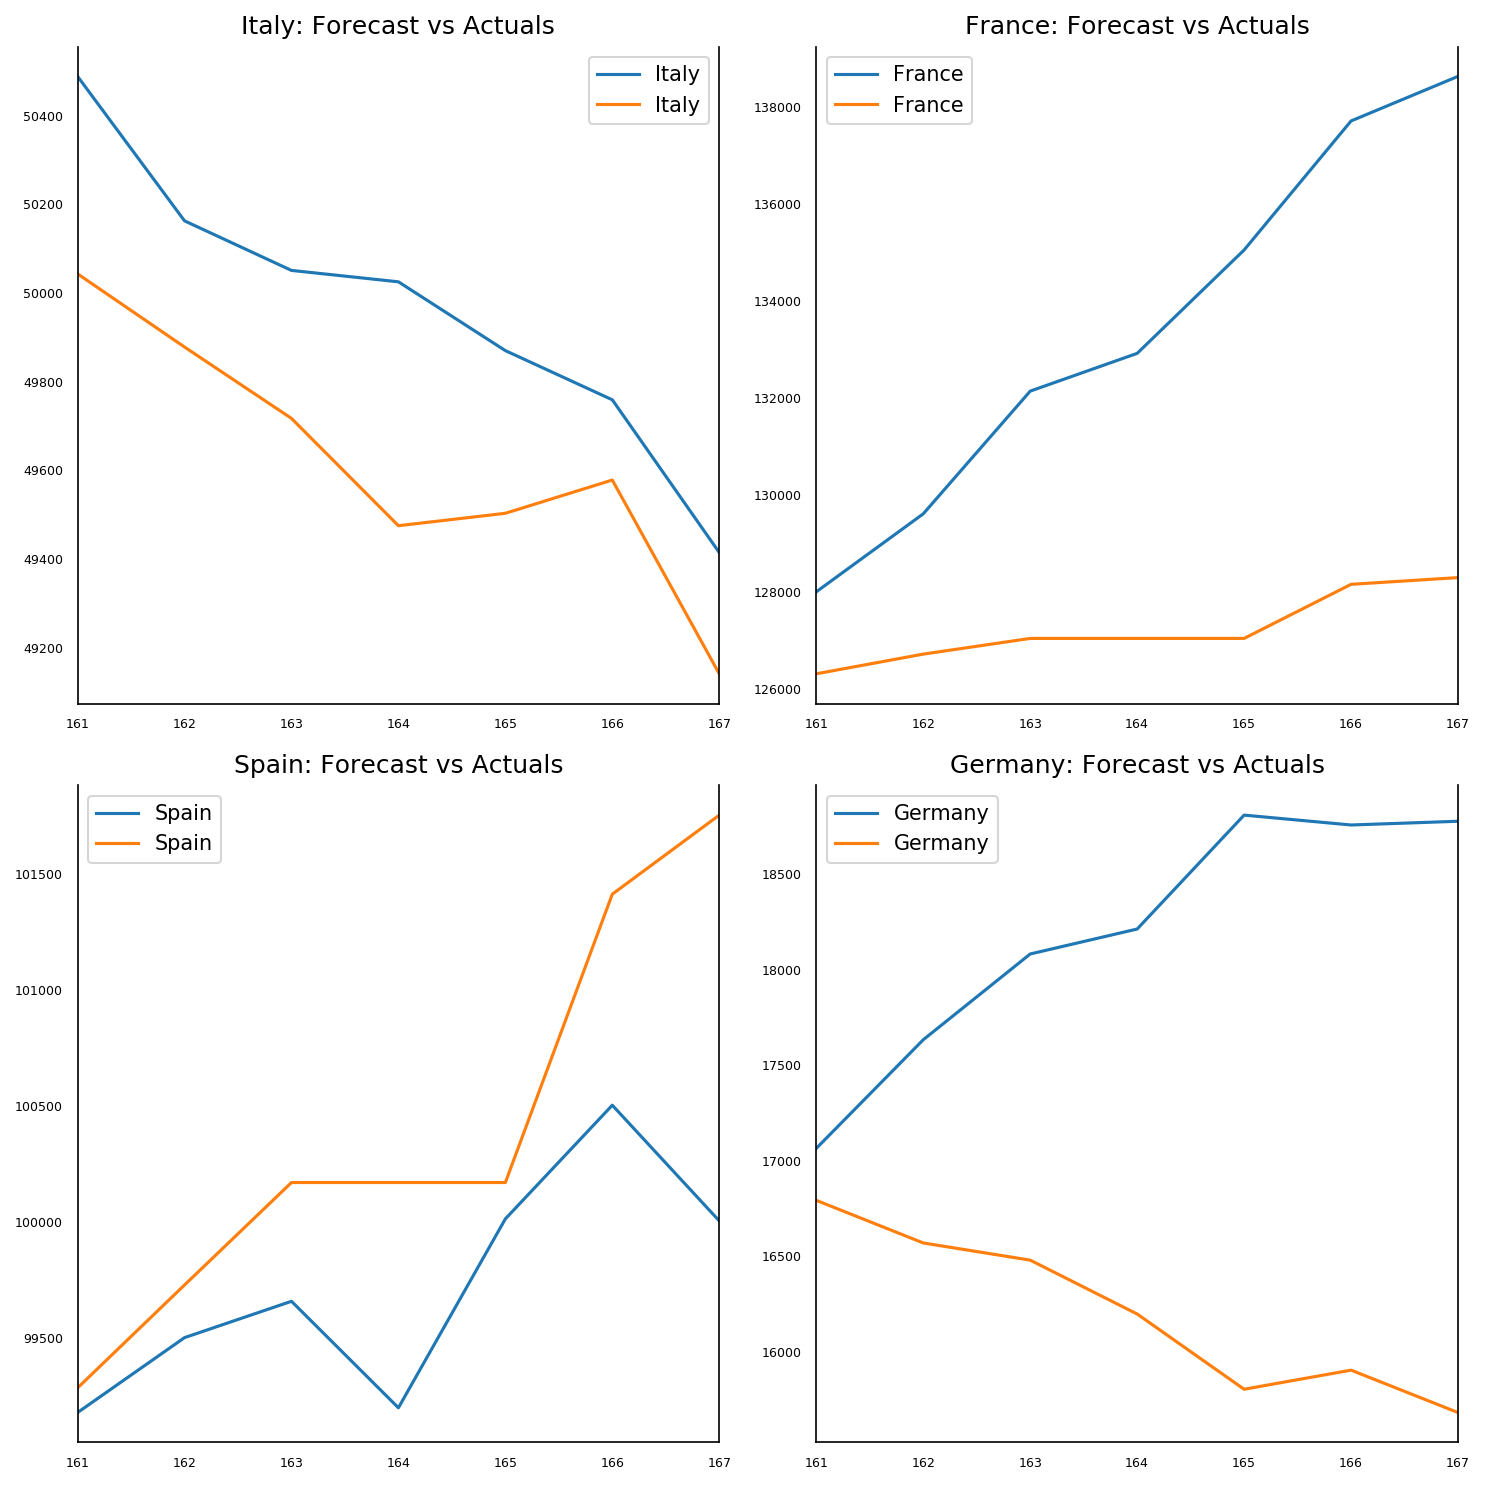

In [151]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [157]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})


for i in list(df_results.loc[:, ['Italy', 'France', 'Spain', 'Germany']].columns):
    print('Forecast Accuracy of: ' + i)
    accuracy_prod = forecast_accuracy(df_results[i].values, df_test[i])
    for k, v in accuracy_prod.items():
        print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Italy
mape   :  0.007
me     :  347.8879
mae    :  347.8879
mpe    :  0.007
rmse   :  365.5775
corr   :  0.9344
minmax :  0.007
Forecast Accuracy of: France
mape   :  0.0487
me     :  6212.9585
mae    :  6212.9585
mpe    :  0.0487
rmse   :  6912.7366
corr   :  0.9496
minmax :  0.046
Forecast Accuracy of: Spain
mape   :  0.0066
me     :  -662.1563
mae    :  662.1563
mpe    :  -0.0066
rmse   :  860.8128
corr   :  0.7783
minmax :  0.0066
Forecast Accuracy of: Germany
mape   :  0.1242
me     :  1987.5777
mae    :  1987.5777
mpe    :  0.1242
rmse   :  2223.717
corr   :  -0.9604
minmax :  0.1075


## LSTM

In [173]:
test_data_size = 40
i = 'Italy'
daily_cases = data_list[0][data_list[0]['Country/Region']==i]['Cases'].values - data_list[1][data_list[1]['Country/Region']==i]['Cases']

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

(128,)

In [174]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [175]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [176]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [177]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [178]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [179]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 53.4029655456543 test loss: 8.333373069763184
Epoch 10 train loss: 24.060157775878906 test loss: 0.91599041223526
Epoch 20 train loss: 20.105152130126953 test loss: 0.13479864597320557
Epoch 30 train loss: 19.297685623168945 test loss: 0.8520019054412842
Epoch 40 train loss: 14.750768661499023 test loss: 9.80897331237793
Epoch 50 train loss: 12.119284629821777 test loss: 16.2668514251709


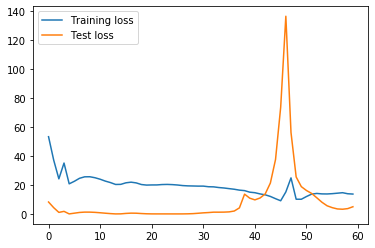

In [181]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
#plt.ylim((0, 5))
plt.legend();